In [10]:
from feature_extractor import *
from preprocessor import *

import matplotlib.pyplot as plt
import numpy as np


In [11]:
#only for ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
import io

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

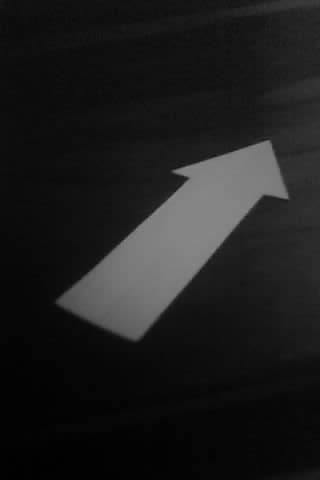

In [12]:


filename = 'samples/s1.jpg'
src = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
showarray(src)

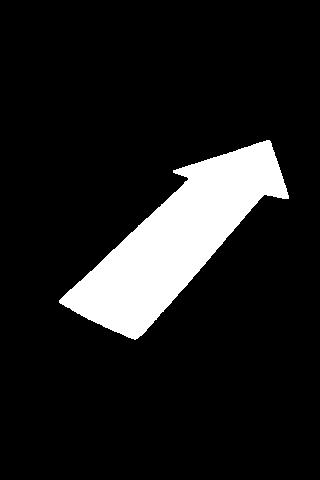

In [13]:
blur = cv2.GaussianBlur(src,(3,3),0)
otsu_thresh = applyOtsu(blur)
src = otsu_thresh
showarray(src)

In [14]:

blobs = extract_blob(src)
largestBlob = getLblob(blobs)
testy1 = largestBlob.lowerY
testy2 = largestBlob.upperY

testx1 = largestBlob.lowerX
testx2 = largestBlob.upperX
#print(testx1, testx2, testy1, testy2)
slice = make_copy(src,testy1, testy2, testx1, testx2)

In [15]:
#TODO: Make sure to differentiate between the wall and the arrow

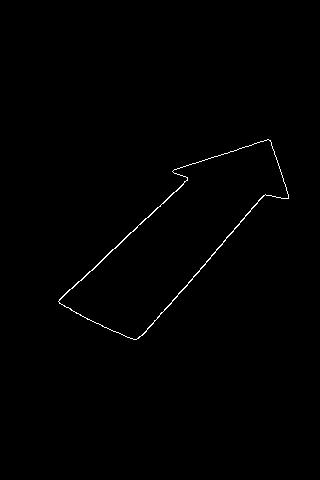

In [16]:
#TODO :add to preprocessor
cannyEdge = cv2.Canny(src, 50, 200, None, 3)
outline = cannyEdge 
showarray(outline)

lines detected:  8


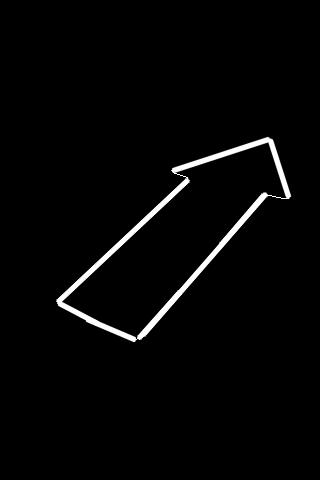

In [17]:
cdst = np.copy(outline)
#TODO: make the short lines intersection parameter a function of the blob size
slines, height= openCV_houghlines(cdst, r_res=1, theta_res=np.pi/180, int_thresh=30, l=None, minPoint_line=20, maxLine_gap=10)
#print(lines_points)
print("lines detected: ", len(slines))
showarray(cdst)


In [ ]:
# the hough P here should be tuned to detect shorter lines 
# the short line on the tail and the arrow head are our predictors

svertices = get_vertices(slines)
distances = get_distances(slines, svertices)
dir_vector = get_arrow_vector(slines[distances[0]], svertices[distances[1]], height)


In [ ]:
#implement the code to find the longest line and do houghp in two steps
#basically the longest lines should give us an idea about the direction\
#this is a strong predictor

In [ ]:
l = slines_points[distances[0]][0]

(270, 340) (288, 284)
(58, 179) (279, 312)


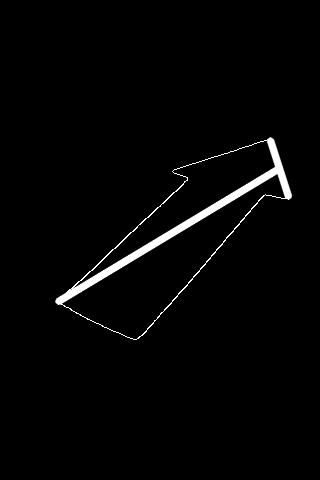

In [ ]:
finalOut = np.copy(outline)
cv2.line(finalOut, (l[0],height-l[1]), (l[2],height-l[3]), (255,255,255), 5, cv2.LINE_AA)
cv2.line(finalOut, (svertices[distances[1]][0], height-svertices[distances[1]][1]), ((l[0]+l[2])//2,  height-((l[1]+l[3]))//2), (255,255,255), 5, cv2.LINE_AA)
print((l[0],l[1]), (l[2],l[3]))
print((svertices[distances[1]][0], svertices[distances[1]][1]), ((l[0]+l[2])//2,  ((l[1]+l[3]))//2))
showarray(finalOut)


In [ ]:

print(dir_vector)


197.81888891452277


Long Lines Here

cdst = np.copy(outline)

lines_points , height= openCV_houghlines(cdst, r_res=1, theta_res=np.pi/180, int_thresh=60, l=None, minPoint_line=20, maxLine_gap=150)
#print(lines_points)
lines_Eqns = get_lines(lines_points)
print("lines detected: ", len(lines_points))
showarray(cdst)

Debug the short line distances here

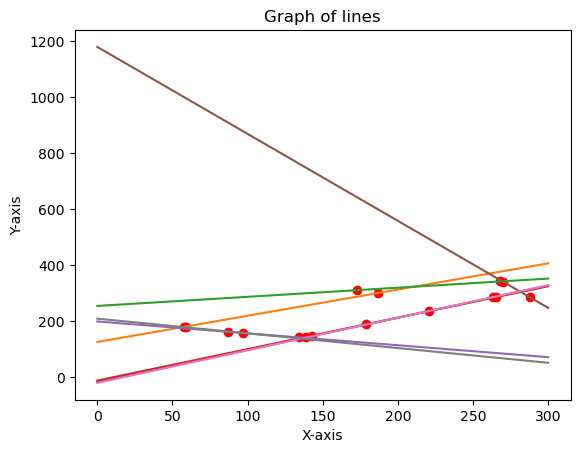

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



x_points=[]
y_points = []

for x, y in svertices:
    x_points.append(x)
    y_points.append(y)
plt.scatter(x_points, y_points, color='red')

x = np.linspace(0, 300, 100)

for m, c in slines_Eqns:
    y = m * x + c
    plt.plot(x,y)


# plt.ylim(-30,height)
# plt.xlim(0,400)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Graph of lines')
plt.show()


In [ ]:
slines=[(-3.111111111111111, 1180.0)]
x_points=[58]
y_points = [179]

clear_output(wait=True)

for x, y in zip(x_points, y_points):
    x_points.append(x)
    y_points.append(y)
plt.scatter(x_points, y_points, color='red')

x = np.linspace(0, 300, 100)

for m, c in slines:
    y = m * x + c
    plt.plot(x,y)


# plt.ylim(-30,height)
# plt.xlim(0,400)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Graph of lines')
plt.show()


In [ ]:
line = []
vertex = []
dis = []


In [ ]:

for sl in slines_Eqns:
    for sv in svertices:
        print(sl,end='\t')
        print(sv,end='\t')
        print(get_dis(sl,sv))


